# UNDERSTANDING THE AUSTIN HOUSING MARKET BY LOOKING AT NEW HOUSING SUPPLY

There are a nearly infinite variety of factors that influence pricing in any housing market, but to simplify things for easier comprehension, it can be helpful to summarize those factors into the categories of supply and demand. If a giant, foreign investment company collapses and liquidates assets in the region, you can just think of it as a bump in supply. If the region is trending as the "Best Place to Move" by influencers and landed major tech company relocations, these are just examples of increases in demand. The most common way to measure the demand in an area is with changes in home pricing. When demand goes up, buyers compete with higher prices. But these forces dont play out in isolation, and as prices rise the incentive for builders and investors to create new housing rises. So another great metric to look at to understand the demand in a housing market is the amount of new construction happening. 

Austin has a great [data set](https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu) containing all of the city's building permits since about 1980, and using this data we can create a chart that shows the demand for new construction over time. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sodapy import Socrata 

# set chart theme
sns.set_theme(context='notebook', 
              style='darkgrid', 
              palette='deep', 
              font='sans-serif', 
              font_scale=1.3, 
              color_codes=True, 
              rc=None
             )

# set pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# turning off warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# delete this part and just import df - put up this code up in git repository later for others to access (along with ML modeling code)

def download_data():
    """Downloading selected building permit data from Austin city API.
    
    note: The data selected is intended to be used to calculate the total new housing units permitted and 
    constructed in Austin, so the permit type, work class and permit class have all been limited to query
    only the permits that result in new housing units being added. Also, the selected data set does not account
    for the housing units that get demolished, so will likely be a higher total count than the actual count.
    """
    URL ='data.austintexas.gov'

    client = Socrata(URL,
                     None,
                     timeout=100) #replace None with my token when I get one
# line 36 , "Shell"
    query = """
        select
                permit_number,
                description,
                permittype,
                work_class,
                housing_units,
                completed_date,
                permit_class,
                status_current,
                issue_date,
                original_zip,
                total_job_valuation,
                council_district,
                condominium,
                number_of_floors
        where
                permittype = "BP"
                and work_class in ("New")
                and permit_class in ( 
                                    "C- 101 Single Family Houses", 
                                    "C- 103 Two Family Bldgs",
                                    "C- 104 Three & Four Family Bldgs", 
                                    "C- 105 Five or More Family Bldgs", 
                                    "C- 106 Mixed Use", 
                                    "R- 101 Single Family Houses", 
                                    "R- 102 Secondary Apartment",
                                    "R- 103 Two Family Bldgs", 
                                    "R- 436 Addn to increase housing units"
    )
        limit 
                1000000

    """

    results = client.get("3syk-w9eu", query=query)

    df = pd.DataFrame.from_dict(results)
    # saving the raw data df
    # df.to_csv("forcast_data.csv")
    
    client.close()
    return  df

# raw = download_data()
# print(raw.shape)
# raw.head(1)


In [3]:
# -------- manipulating the data ------

# adding col for building type

def adding_building_type(df):
    """take austin housing data df and classify building 1 fam, 2-4 fam or 5+"""
    
    # dictionary for mapping values
    class_d = {
        "C- 101 Single Family Houses":'single family',
        "R- 101 Single Family Houses":'single family',
        'C- 103 Two Family Bldgs': '2-4 family',
        'C- 104 Three & Four Family Bldgs': '2-4 family',
        'R- 102 Secondary Apartment': 'single family',
        'R- 103 Two Family Bldgs': '2-4 family',
        'R- 436 Addn to increase housing units': '2-4 family',
        'C- 105 Five or More Family Bldgs': '5+ family',
        'C- 106 Mixed Use': '5+ family'}                                   

    df['type'] = df['permit_class'].map(class_d)
    return df

def transform_data(df):
    """Take in selected columns from selected building permits and aggregate to return a dataframe with total
    new housing unit count permitted and finalized new housing unit count for each year.
    """

     # turning housing units value into integer
    df['Housing Units'] = df['housing_units'].astype('float')   

    # filling zero values for single family homes
    mask = (
            (df['type']=='single family') & 
            (df['Housing Units']==0)
    )
    df.loc[mask,'Housing Units'] = 1
    # df['housing_units'].fillna(0, inplace=True) - this is a legacy line, prob for total database
    
    df['issue_date'] = pd.to_datetime(df['issue_date'])
    df['completed_date'] = pd.to_datetime(df['completed_date'])
    
    return df
    
def add_condo_type(df):
    """adding condo type category to type column"""
    mask = df['condominium']=='Yes'
    df.loc[mask, 'type'] = 'condo'
    return df

def adjust_errors(df):
    """adjusting values for one error outlier"""
    error_mask = df['permit_number']=='2003-014585 BP'
    df.loc[error_mask, 'Housing Units'] = 1
    df.loc[error_mask, 'type'] = 'single family'
    return df

# df = adding_building_type(raw)
# df = add_condo_type(df)
# df = transform_data(df)
# df = adjust_errors(df)

# df_filter = df['status_current'].isin(['Final', 'Active'])
# df = df[df_filter].copy()
# df.head(1)

#df.to_csv('data_2-22-2022.csv')

In [4]:
df = pd.read_csv('data_2-22-2022.csv',
                 index_col=0,
                 parse_dates=['issue_date', 'completed_date'],
                 infer_datetime_format=True)

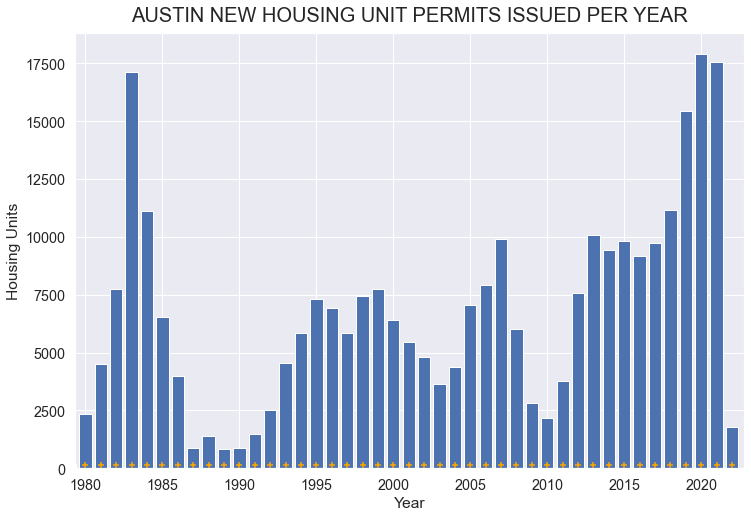

In [5]:
# graphing demand as permits per year

fig, axs = plt.subplots(figsize=(12, 8))
h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()

axs.bar(h.index, height = h)
axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color='orange')
plt.xlabel("Year")
plt.xlim([pd.to_datetime('1979-01-01').year+.3, pd.to_datetime('2023-01-01').year-.2])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNIT PERMITS ISSUED PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
plt.savefig("1.png", facecolor='w')
plt.show()

In [6]:
df_mask = df['status_current'].isin(['Final', 'Active'])
df[df_mask].shape

(118665, 16)

The above chart is a way of representing the demand for housing in Austin. Now it is easy to see that there was a lot of demand for housing in 1983, and very little demand for housing in 1990. But to have context to understand the relative value of the demand we need to illustrate the supply. Below, I use the same dataset but instead of housing units permitted, I use the number of housing units that are built and arrive to the market for each year.

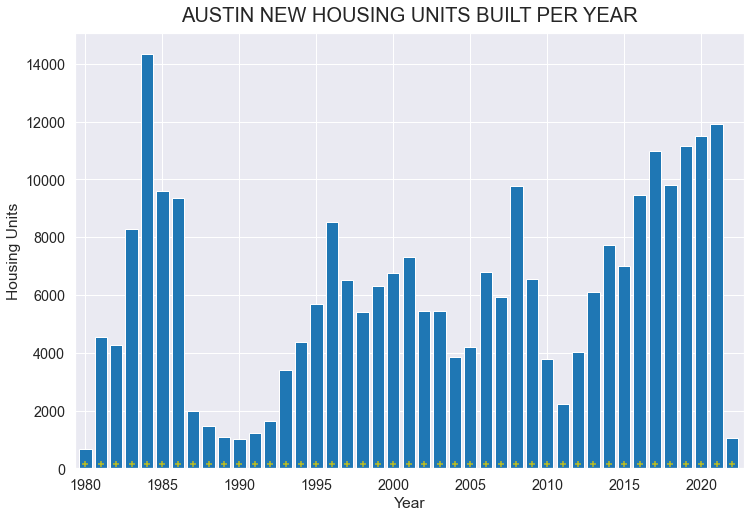

In [7]:
# graphing demand with supply as units built per year
qualitative_colors = sns.color_palette("tab10", 10)

#h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

fig, axs = plt.subplots(figsize=(12, 8))


axs.bar(b.index, height = b, label='Housing Supply', color = qualitative_colors[0])
axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color=qualitative_colors[8]) 
#axs.plot(b.index, b, marker='o', label = 'Housing Supply', color=qualitative_colors[1] )


plt.xlabel("Year")
plt.xlim([pd.to_datetime('1979-01-01').year+.3, pd.to_datetime('2023-01-01').year-.2])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNITS BUILT PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.savefig("2.png", facecolor='w')
plt.show()


Although these measures seem very similar, they can be quite different because of the time it takes to build housing units to fulfill the demand. These measures would be identical if housing could be built instantly, but some large, multi-unit buildings can take 3+ years to arrive to market and a lot can change in that time. Below are the supply and demand values plotted as lines. Notice how the peaks and valleys of the supply line are similar to the demand peaks and valleys, but offset by about a year or two. 

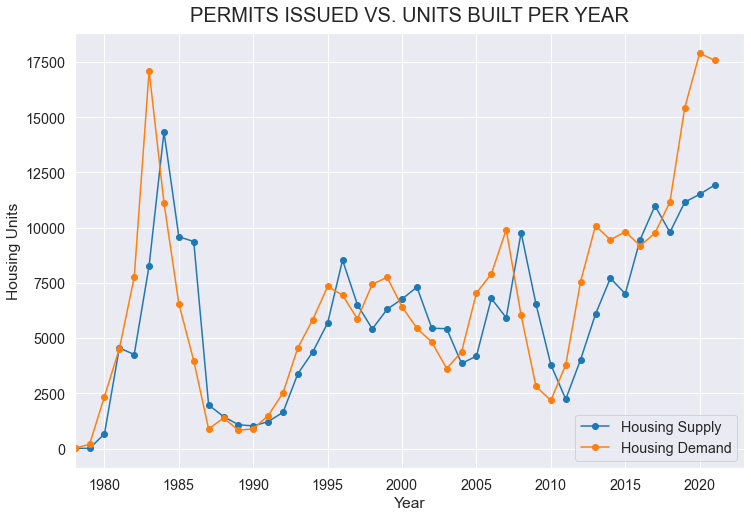

In [8]:
# graphing demand with supply as units built per year
qualitative_colors = sns.color_palette("tab10", 10)

df_filter = df['status_current'].isin(['Final', 'Active'])

h = df[df_filter].groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df[df_filter].groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = h.index < pd.to_datetime('2022-01-01').year
b_limit_mask = b.index < pd.to_datetime('2022-01-01').year

fig, axs = plt.subplots(figsize=(12, 8))

axs.plot(b.index[b_limit_mask], b[b_limit_mask], marker='o', label='Housing Supply', color = qualitative_colors[0])
#axs.scatter(h.index, [150 for x in range(len(h.index))], marker='+', color=qualitative_colors[8], label='Year Marker')
axs.plot(h.index[h_limit_mask], h[h_limit_mask], marker='o', label = 'Housing Demand', color=qualitative_colors[1] )


plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title("PERMITS ISSUED VS. UNITS BUILT PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
plt.legend()
plt.savefig("3.png", facecolor='w')
plt.show()

Also notice how the lines cross back and forth, years where the orange line is on top means that more housing units were demanded than were able to be produced, and years when the blue line is on top means that more housing units were built than new units were demanded. In this instance, we know that the demand is causal because a permit getting issued causes a unit to be built, and a unit can NOT be built unless a permit is issued first. If we frame this graph in terms of the difference between demand and supply we can see the number of "unbuilt" houses per year. Think of this yearly "unbuilt" as the annual housing supply "deficit" and this deficit can be positive or negative. In years where the orange line is on top there is a positive housing deficit that adds to the cumulative total of housing units that are permitted but not built, and years where the blue line is on top the deficit is negative and reduces the running total number of unbuilt housing units. While the deficit can be positive or negative on a given year, the running total or housing unit "debt" can only go as low as zero, since a negative number would mean that more housing units have been built than have been permitted overall.  

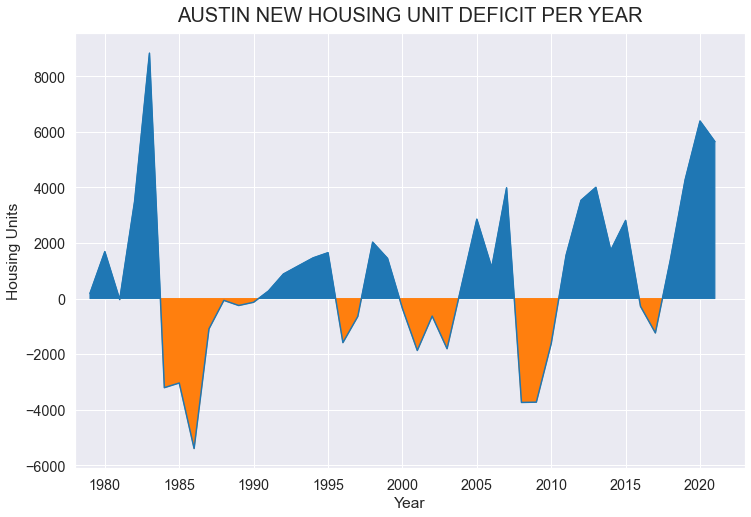

In [9]:
# charting the annual deficit
qualitative_colors = sns.color_palette("tab10", 10)

h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = (
                (h.index < pd.to_datetime('2022-01-01').year) &
                (h.index > pd.to_datetime('1978-01-01').year)
)

b_limit_mask = (
                (b.index < pd.to_datetime('2022-01-01').year) &
                (b.index > pd.to_datetime('1978-01-01').year)
)

fig, axs = plt.subplots(figsize=(12, 8))

# calculating the deficit values
deficit = h[h_limit_mask] - b[b_limit_mask]

axs.plot(h.index[h_limit_mask], deficit,  label = 'Housing Demand', color=qualitative_colors[0], animated=True, fillstyle='full' )

plt.fill_between(
    h.index[h_limit_mask],
    y1=deficit,
    y2=0,
    where=deficit > 0,
    interpolate=True,
    color=qualitative_colors[0]
)
plt.fill_between(
    h.index[h_limit_mask],
    y1=deficit,
    y2=0,
    where=deficit < 0,
    interpolate=True,
    color=qualitative_colors[1]
)

plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title("AUSTIN NEW HOUSING UNIT DEFICIT PER YEAR", pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.savefig("4.png", facecolor='w')
plt.show()

This graph is pretty hard to make sense of by itself, but what we can see is that what goes up seems to come back down. Why is this? Simply put: overbuilding. There is a positive feedback loop where when supply becomes low, demand will be relatively higher raising prices and incentivizing new construction until the supply becomes high enough to cause prices to drop and building to slow. But because some large buildings can take years to complete, the demand will often be satisfied before the market can send the signal to builders to stop building. The result is overbuilding, there is more housing supply than the market demands. Notice here how the level of building seems to correspond to the level of deficit that follows. 

But the market does not work well if it is too "tight", having a little bit of excess housing in the market allows for new people to enter the market and for people to have options when they decide to move. Below we take a look at the Austin housing market in terms of cumulative deficit, or housing supply "debt" for each year. 

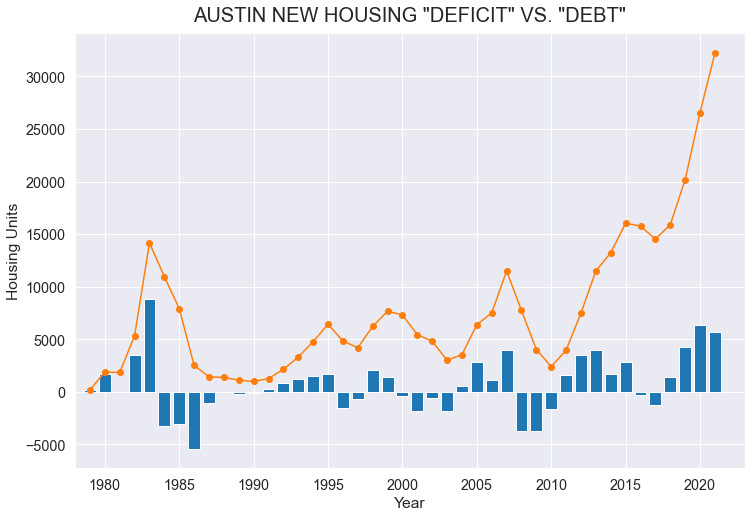

In [10]:
# aggregate housing supply "debt"
qualitative_colors = sns.color_palette("tab10", 10)

h = df.groupby(df['issue_date'].dt.year, axis=0)['Housing Units'].sum()
b = df.groupby(df['completed_date'].dt.year, axis=0)['Housing Units'].sum()

# limit mask to only show completed data (through 2021, NOT including 2022)
h_limit_mask = (
                (h.index < pd.to_datetime('2022-01-01').year) &
                (h.index > pd.to_datetime('1978-01-01').year)
)

b_limit_mask = (
                (b.index < pd.to_datetime('2022-01-01').year) &
                (b.index > pd.to_datetime('1978-01-01').year)
)

fig, axs = plt.subplots(figsize=(12, 8))

# calculating the deficit values
debt = (h[h_limit_mask] - b[b_limit_mask]).cumsum()

axs.plot(h.index[h_limit_mask], debt,  label = 'Housing Demand', color=qualitative_colors[1], marker='o' )
axs.bar(h.index[h_limit_mask], height=deficit, color=qualitative_colors[0])

plt.xlabel("Year")
plt.xlim([pd.to_datetime('1978-01-01').year, pd.to_datetime('2023-01-01').year])
plt.ylabel("Housing Units")
plt.title('AUSTIN NEW HOUSING "DEFICIT" VS. "DEBT"', pad=12, fontdict = {'fontsize':20, 'fontweight':'light'})
#plt.legend()
plt.savefig("5", facecolor='w')
plt.show()


What you probably notice about that chart is that the number of housing units currently being built right now is really, really high compared to historical norms. 

### I. Why is this the case? 

1) Most of the housing under construction are, large multi-family buildings, like apartment buildings or multi-story condominiums.

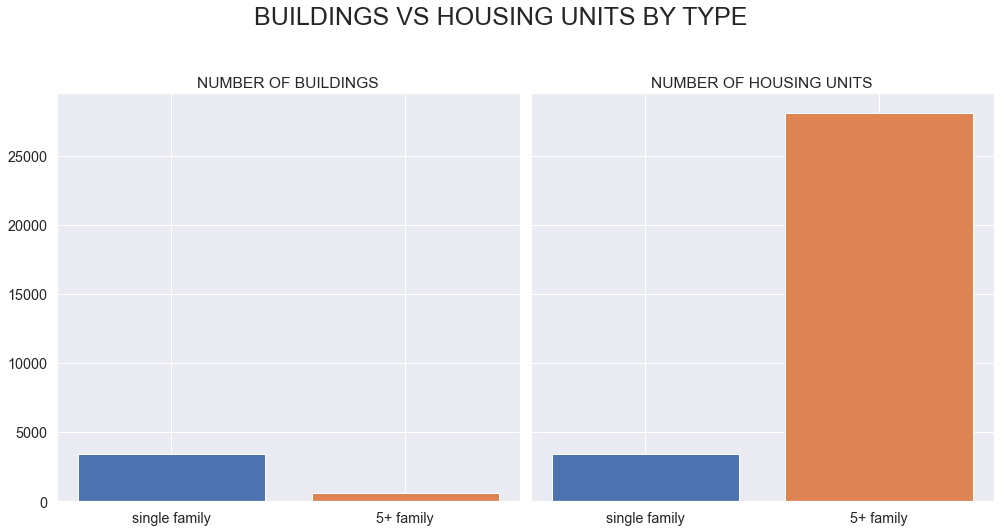

In [11]:
# separating df into finished and active building dfs

def non_completed(df):
    """returns df containing active, unfinished building permits for New housing units"""
    non_completed_mask = (
                            (df['completed_date'].isnull()) & 
                            (df['status_current'] == 'Active')
    )
    non = df[non_completed_mask].copy().reset_index(drop = True)
    return non

def completed(df):
    """returns df containing building permits from completed and finalized buildings with new housing units"""
    completed_mask = (
                        (df['completed_date'].notnull()) & 
                        (df['status_current']=='Final')
    )
    fin = df[completed_mask].copy().reset_index(drop = True)
    return fin

active = non_completed(df)
finished = completed(df)

# buildings counts by type on same scale

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(14,7))
fig.suptitle('BUILDINGS VS HOUSING UNITS BY TYPE', size=25, weight=30, y=1.05)
for types in ['single family', '5+ family']:
    mask = active['type']==types
    ax1.bar(types, height=active['Housing Units'][mask].count())
    ax1.set_title('NUMBER OF BUILDINGS')
for types in ['single family', '5+ family']:
    mask = active['type']==types
    ax2.bar(types, height=active['Housing Units'][mask].sum())
    ax2.set_title('NUMBER OF HOUSING UNITS')

for ax in fig.get_axes():
    ax.label_outer()
plt.tight_layout()  

plt.savefig('6.png', facecolor='w')
plt.show()

While there are 5X more single family homes than 5+ family buildings currently being built, there are over 8X as many housing units produced by the 5+ family buildings. This means that nearly 90% of all the housing currently under construction is in these large, multifamily buildings. 

---
2) Multifamily buildings take significantly longer to build than single family housing. 

In [12]:
def build_timedelta(df):
    """add column for build days as integer"""
    
    # timedelta = datetime(end) - datetime(start)   ---> make sure these series have been converted to datetime values
    build_time = df['completed_date'] - df['issue_date']
    
    # series = timedelta as int(days)
    df['build_days'] = build_time.dt.days
    return df

finished = build_timedelta(finished)

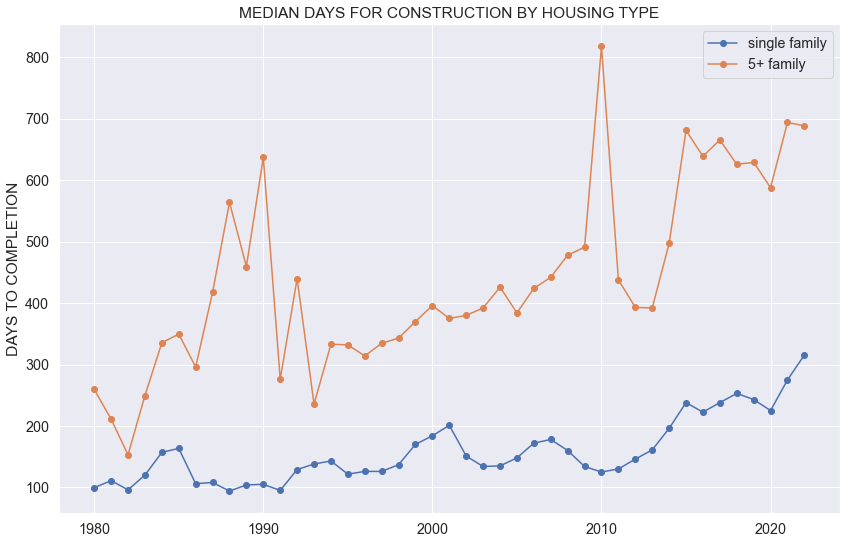

In [13]:
# charting median build times for single fam vs 5+ over time


mask = (finished['build_days']>=40) & (finished['build_days']<1500)
built = finished[mask].pivot_table(index=finished['completed_date'].dt.year, columns='type', values='build_days', aggfunc=np.median)

types = ['single family', '5+ family']
years = built.index > 1979

plt.figure(figsize=(14,9))
for t in types:
    plt.plot(built.index[years], built[t][years], marker='o', label=t)    
plt.ylabel('DAYS TO COMPLETION')
plt.title('MEDIAN DAYS FOR CONSTRUCTION BY HOUSING TYPE')
plt.legend()

plt.savefig('7.png', facecolor='w')
plt.show()

At 610 days, 5+ family buildings have a median build time almost 3X as long as the median build time of single family homes. 

---
3) Supply chain and Covid related delays have added additional time to getting these larger buildings to market.

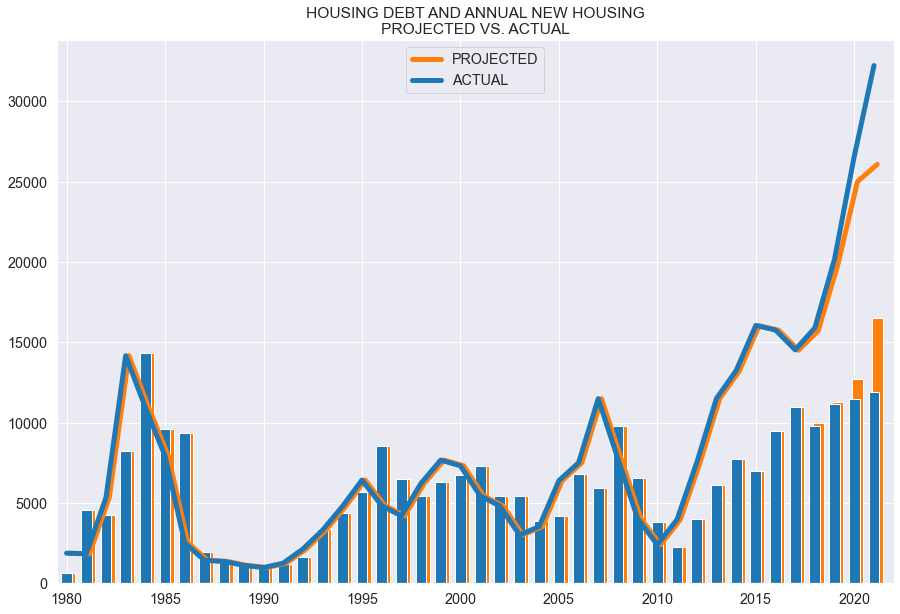

In [14]:
# importing data with ML modeled completion dates
c = pd.read_csv('compiled.csv', index_col=0) #data set with projections
b = pd.read_csv('built.csv', index_col=0) #data set with 'actual' values

supply = c.pivot_table(index='c_date', columns='type', values='Housing Units', aggfunc=np.sum)
demand = c.pivot_table(index='i_date', columns='type', values='Housing Units', aggfunc=np.sum)

supply = supply.set_index(pd.to_datetime(supply.index), drop = True) 
demand = demand.set_index(pd.to_datetime(demand.index), drop = True)
built = b.set_index(pd.to_datetime(b.index), drop = True)

supply_m = supply.resample("y", label='left').sum() # df with ML model data, pivoted on completion date (no time delay added)
demand_m = demand.resample("y", label='left').sum() # df pivoted on issue date
built_m = built.resample("y", label='left').sum() # df with no ML data, pivoted on completion date

# adding type values back together (total) and cumulatively (tally)
cols = ['2-4 family', '5+ family', 'condo', 'single family']

supply_m['total'] = supply_m[cols].sum(axis=1)
supply_m['tally'] = supply_m['total'].cumsum()

demand_m['total'] = demand_m[cols].sum(axis=1)
demand_m['tally'] = demand_m['total'].cumsum()

built_m['total'] = built_m[cols].sum(axis=1)
built_m['tally'] = built_m['total'].cumsum()

# plotting

plt.figure(figsize=(15,10))

# filter to cut of chart dates at 2021
syear_mask = (supply_m.index > pd.to_datetime('1979-01-01')) & (supply_m.index < pd.to_datetime('2021-12-31'))
dyear_mask = (demand_m.index > pd.to_datetime('1979-01-01')) & (demand_m.index < pd.to_datetime('2021-12-31'))
byear_mask = (built_m.index > pd.to_datetime('1979-01-01')) & (built_m.index < pd.to_datetime('2021-12-31'))

#plotting yearly totals

plt.plot(demand_m.index[dyear_mask]+ pd.Timedelta(60, unit='days'),
         demand_m['tally'][dyear_mask] - supply_m['tally'][syear_mask],
         color=qualitative_colors[1],
         lw=5, 
         label='PROJECTED')

plt.plot(demand_m.index[dyear_mask],
         demand_m['tally'][dyear_mask] - built_m['tally'][byear_mask], 
         color=qualitative_colors[0], 
         lw=5, 
         label='ACTUAL')

plt.bar(supply_m.index[syear_mask]+ pd.Timedelta(60, unit='days'), 
        height=(supply_m['total'][syear_mask]), 
        width=200, 
        color=qualitative_colors[1], 
        label='')

plt.bar(supply_m.index[syear_mask], 
        height=(built_m['total'][byear_mask]), 
        width=200, 
        color=qualitative_colors[0], 
        label='')

plt.title('HOUSING DEBT AND ANNUAL NEW HOUSING\nPROJECTED VS. ACTUAL')
plt.legend(loc='upper center')
plt.xlim([pd.to_datetime('1979-07') , pd.to_datetime('2022-01')])

plt.savefig('8.png', facecolor='w')
plt.show()

Using a machine learning model to forcast completion dates for the active permits, I generated a view of how we would expect to see housing supply to arrive to the market in more normal times. It is important to note here that this model is just an estimate, and that I am making the assumption that the differences in between the model and the actual values are solely attributable to delays and uncertaintly caused by Covid. In reality, it is much more complex than that, but these models and assumptions can be helpful tools to identify trends using counterfactual events that would otherwise be impossible to measure. 

---
4) These large buildings taking extra time to get to market has broken the natural feedback loop that disincentivizes additional construction and prevents overbuilding which can contribute to long periods of home price stagnation or decline.

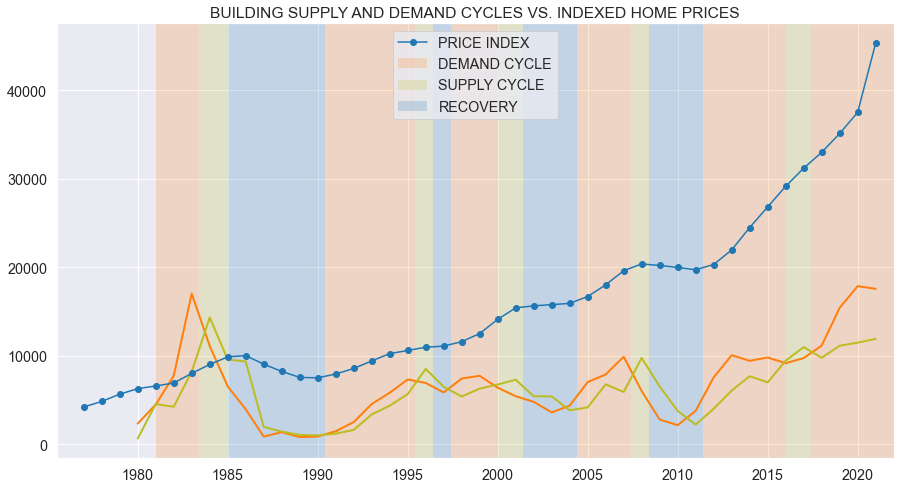

In [15]:
# importing price index data
pi = pd.read_csv('austin_p_index.csv', index_col=0, names=['price'], header=0)
pi.index= pd.to_datetime(pi.index)
pi= pi.resample("y", label='left').mean()


c = pd.read_csv('compiled.csv', index_col=0) #data set with projections
b = pd.read_csv('built.csv', index_col=0) #data set with 'actual' values

supply = c.pivot_table(index='c_date', columns='type', values='Housing Units', aggfunc=np.sum)
demand = c.pivot_table(index='i_date', columns='type', values='Housing Units', aggfunc=np.sum)

supply = supply.set_index(pd.to_datetime(supply.index), drop = True) 
demand = demand.set_index(pd.to_datetime(demand.index), drop = True)
built = b.set_index(pd.to_datetime(b.index), drop = True)

supply_q = supply.resample("y", label='left').sum() # df with ML model data, pivoted on completion date (no time delay added)
demand_q = demand.resample("y", label='left').sum() # df pivoted on issue date
built_q = built.resample("y", label='left').sum() # df with no ML data, pivoted on completion date

# adding type values back together (total) and cumulatively (tally)
cols = ['2-4 family', '5+ family', 'condo', 'single family']

supply_q['total'] = supply_q[cols].sum(axis=1)
supply_q['tally'] = supply_q['total'].cumsum()

demand_q['total'] = demand_q[cols].sum(axis=1)
demand_q['tally'] = demand_q['total'].cumsum()

built_q['total'] = built_q[cols].sum(axis=1)
built_q['tally'] = built_q['total'].cumsum()

# plotting

plt.figure(figsize=(15,8))

# filter to cut of chart dates at 2021
sq_mask = (supply_q.index > pd.to_datetime('1979-01-01')) & (supply_q.index < pd.to_datetime('2021-12-31'))
dq_mask = (demand_q.index > pd.to_datetime('1979-01-01')) & (demand_q.index < pd.to_datetime('2021-12-31'))
bq_mask = (built_q.index > pd.to_datetime('1979-01-01')) & (built_q.index < pd.to_datetime('2021-12-31'))

#plotting yearly totals

plt.plot(demand_q.index[dq_mask],
         demand_q['total'][dq_mask],
         color=qualitative_colors[1],
         lw=2, 
         label='')

plt.plot(demand_q.index[dq_mask],
         built_q['total'][bq_mask], 
         color=qualitative_colors[8], 
         lw=2, 
         label='')

plt.plot(pi.index, pi['price']*500, color=qualitative_colors[0], label='PRICE INDEX',marker='o')

plt.axvspan(pd.to_datetime('1981-01'), pd.to_datetime('1983-06'), color=qualitative_colors[1], alpha=0.2, lw=0, label='DEMAND CYCLE')
plt.axvspan(pd.to_datetime('1983-06'), pd.to_datetime('1985-01'), color=qualitative_colors[8], alpha=0.2, lw=0, label='SUPPLY CYCLE')
plt.axvspan(pd.to_datetime('1985-01'), pd.to_datetime('1990-06'), color=qualitative_colors[0], alpha=0.2, lw=0, label='RECOVERY')
plt.axvspan(pd.to_datetime('1990-06'), pd.to_datetime('1995-06'), color=qualitative_colors[1], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('1995-06'), pd.to_datetime('1996-06'), color=qualitative_colors[8], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('1996-06'), pd.to_datetime('1997-06'), color=qualitative_colors[0], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('1997-06'), pd.to_datetime('2000-01'), color=qualitative_colors[1], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2000-01'), pd.to_datetime('2001-06'), color=qualitative_colors[8], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2001-06'), pd.to_datetime('2004-06'), color=qualitative_colors[0], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2004-06'), pd.to_datetime('2007-06'), color=qualitative_colors[1], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2007-06'), pd.to_datetime('2008-06'), color=qualitative_colors[8], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2008-06'), pd.to_datetime('2011-06'), color=qualitative_colors[0], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2011-06'), pd.to_datetime('2016-01'), color=qualitative_colors[1], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2016-01'), pd.to_datetime('2017-06'), color=qualitative_colors[8], alpha=0.2, lw=0)
plt.axvspan(pd.to_datetime('2017-06'), pd.to_datetime('2022-01'), color=qualitative_colors[1], alpha=0.2, lw=0)

plt.title('BUILDING SUPPLY AND DEMAND CYCLES VS. INDEXED HOME PRICES')
plt.legend(loc='upper center')
plt.xlim([pd.to_datetime('1975-07') , pd.to_datetime('2022-01')])

plt.savefig('9.png', facecolor='w')
plt.show()



Here we see the normal cycles of building playing out. As home prices rise, builders and investors are incentivized to build new housing so we see the number of housing units permitted go up. As the waves of new housing arrive to the market, the market balance begins to shift from favoring sellers to favoring buyers, disincentivizing builders from seeking additional permits. However, the housing already in progress will likely continue to arrive to the market beginning to drive prices down. Currently, Austin is experiencing unprecendented amounts of demand for new housing, but the large scale of some of these projects underway combined with building delays has resulted in broken feedback loop as skyrocketing prices continue to encourage even more building. 

### II. Why does this matter?

In a perfect market, the lines for construction supply and demand would track parallel to eachother and in optimal proportion to the market demand. The real world market is more like a game of musical chairs where the person putting out the chairs does not know how many people will be playing. The game becomes very intense if more people play than were expected, but if too many chairs are put out then there is no competition necessary at all. 

So how many people are playing the game and how many chairs are there?

Are we overbuilding?
When will this tsunami of pent-up supply arrive?
will it outstrip the demand and collapse the Austin housing market?


In [16]:
# side by side graphs of population pct change and total population
ppl = pd.read_csv("city_population_data.csv", index_col=0)
issued = df.pivot_table(index=df['issue_date'].dt.year, values='Housing Units', aggfunc=np.sum)
issued.columns = ['units_issued']
completed = df.pivot_table(index=df['completed_date'].dt.year, values='Housing Units', aggfunc=np.sum)
completed.columns = ['units_completed']

piv = pd.merge(left=issued, right=completed, left_index=True, right_index=True, how='outer')
piv = pd.merge(left=piv, right=ppl, how='left', left_index=True, right_on='year')
piv['units_completed'].fillna(0, inplace=True)
piv['units_issued'].fillna(0,inplace=True)

piv.set_index('year',inplace=True)

#adding a column for housing units
piv['hu_ctotal'] = 0

#this is a known variable from the above website
HOUSING_UNITS_2015 = 405_387
#filter for the row of year 2015
mask = piv.index == pd.to_datetime('2015').year
piv.loc[mask, 'hu_ctotal'] = HOUSING_UNITS_2015

# adding housing unit values for years less than 2015
mask = piv.index < pd.to_datetime('2015').year

for i, year in enumerate(piv.index[mask].sort_values(ascending=False)):
    mask1 = piv.index == (2015 - i)
    added = piv.loc[mask1,'units_completed'].sum()
    #print(added)
    current = piv.loc[mask1, 'hu_ctotal'].sum()
    #print(current)
    previous = current - added
    mask2 = piv.index == year
    piv.loc[mask2, 'hu_ctotal'] = previous
    
# adding housing unit values for years over 2015
mask = piv.index > 2015
for i, year in enumerate(piv.index[mask]):
    # selecting previous year for old total
    mask1 = piv.index == (2015 + i)
    current = piv.loc[mask1, 'hu_ctotal'].sum()
   # selecting current year for units added
    mask2 = piv.index==year
    added = piv.loc[mask2,'units_completed'].sum()
    next_year = current + added
    piv.loc[mask2, 'hu_ctotal'] = next_year

#adding a column for housing units
piv['hu_itotal'] = 0

#this is a known variable from the above website
mask_1979 = piv.index==pd.to_datetime('1979').year
HOUSING_UNITS_1979 = piv.loc[mask_1979, 'hu_ctotal'].sum()
#filter for the row of year 1979
mask = piv.index == pd.to_datetime('1979').year
piv.loc[mask, 'hu_itotal'] = HOUSING_UNITS_1979
# adding values
mask = piv.index > 1979
for i, year in enumerate(piv.index[mask]):
    # selecting previous year for old total
    mask1 = piv.index == (1979 + i)
    current = piv.loc[mask1, 'hu_itotal'].sum()
    # selecting current year for units added
    mask2 = piv.index==year
    added = piv.loc[mask2,'units_issued'].sum()
    next_year = current + added
    piv.loc[mask2, 'hu_itotal'] = next_year
    
piv['pop%'] = piv['population'].pct_change()
piv['huc%'] = piv['hu_ctotal'].pct_change()
piv['hui%'] = piv['hu_itotal'].pct_change()

piv = piv[piv.index >= 1980].copy()
#piv.to_csv('piv.csv')

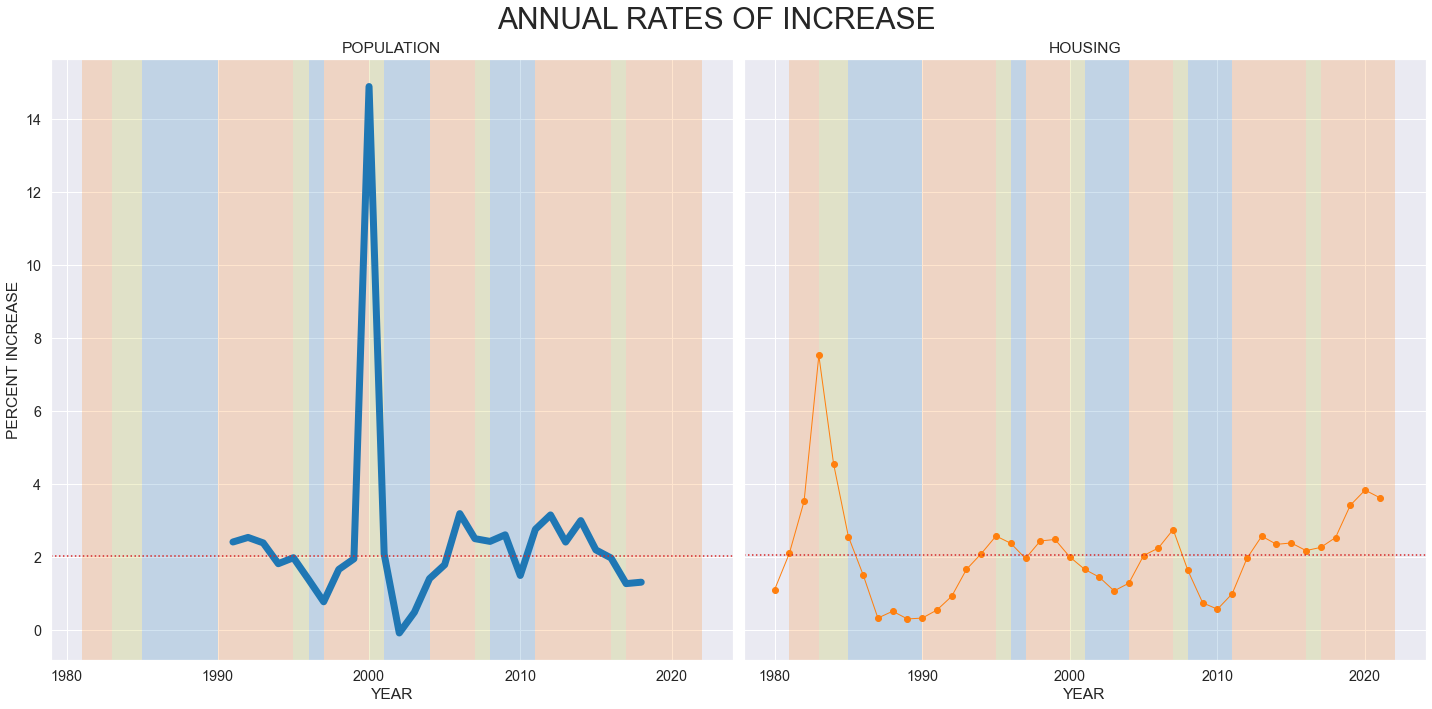

In [17]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey=True)
plt.suptitle('ANNUAL RATES OF INCREASE', size=30 )

mask = piv.index <= 2018
ax1.set_title('POPULATION')
ax1.plot(piv.index[mask], piv['pop%'][mask]*100, color=qualitative_colors[0], lw=7, label= 'CITY POPULATION')
ax1.axhline((piv['pop%'][mask]*100).median(), color=qualitative_colors[3], label='MEDIAN', ls=':')
ax1.set_ylabel('PERCENT INCREASE')
ax1.set_xlabel('YEAR')

ax1.axvspan(pd.to_datetime('1981-01').year, pd.to_datetime('1983-06').year , color=qualitative_colors[1], alpha=0.2, lw=0, label='DEMAND CYCLE')
ax1.axvspan(pd.to_datetime('1983-06').year, pd.to_datetime('1985-01').year, color=qualitative_colors[8], alpha=0.2, lw=0, label='SUPPLY CYCLE')
ax1.axvspan(pd.to_datetime('1985-01').year, pd.to_datetime('1990-06').year, color=qualitative_colors[0], alpha=0.2, lw=0, label='RECOVERY')
ax1.axvspan(pd.to_datetime('1990-06').year, pd.to_datetime('1995-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('1995-06').year, pd.to_datetime('1996-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('1996-06').year, pd.to_datetime('1997-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('1997-06').year, pd.to_datetime('2000-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2000-01').year, pd.to_datetime('2001-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2001-06').year, pd.to_datetime('2004-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2004-06').year, pd.to_datetime('2007-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2007-06').year, pd.to_datetime('2008-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2008-06').year, pd.to_datetime('2011-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2011-06').year, pd.to_datetime('2016-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2016-01').year, pd.to_datetime('2017-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax1.axvspan(pd.to_datetime('2017-06').year, pd.to_datetime('2022-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)

#ax1.legend()

mask = piv.index <= 2021
ax2.set_title('HOUSING')
ax2.plot(piv.index[mask], piv['hui%'][mask]*100, color=qualitative_colors[1], lw=1, marker='o',label='issued')
ax2.axhline((piv['hui%'][mask]*100).median(), color=qualitative_colors[3], label='MEDIAN', ls=':')
ax2.set_xlabel('YEAR')

#ax2.plot(piv.index[mask], piv['huc%'][mask]*100, color=qualitative_colors[2], lw=1, marker='o', label='completed')
#ax2.axhline((piv['huc%'][mask]*100).mean(), color=qualitative_colors[2], label='MEAN', ls=':')


ax2.axvspan(pd.to_datetime('1981-01').year, pd.to_datetime('1983-06').year , color=qualitative_colors[1], alpha=0.2, lw=0, label='DEMAND CYCLE')
ax2.axvspan(pd.to_datetime('1983-06').year, pd.to_datetime('1985-01').year, color=qualitative_colors[8], alpha=0.2, lw=0, label='SUPPLY CYCLE')
ax2.axvspan(pd.to_datetime('1985-01').year, pd.to_datetime('1990-06').year, color=qualitative_colors[0], alpha=0.2, lw=0, label='RECOVERY')
ax2.axvspan(pd.to_datetime('1990-06').year, pd.to_datetime('1995-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1995-06').year, pd.to_datetime('1996-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1996-06').year, pd.to_datetime('1997-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1997-06').year, pd.to_datetime('2000-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2000-01').year, pd.to_datetime('2001-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2001-06').year, pd.to_datetime('2004-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2004-06').year, pd.to_datetime('2007-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2007-06').year, pd.to_datetime('2008-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2008-06').year, pd.to_datetime('2011-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2011-06').year, pd.to_datetime('2016-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2016-01').year, pd.to_datetime('2017-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2017-06').year, pd.to_datetime('2022-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)

#ax2.legend()

plt.tight_layout()

plt.savefig('10.png', facecolor='w')
plt.show()

Here we can see that these increases seem to tend back towards their averages over time. While the actual line of best fit slightly decreases over time, these mean lines provides nice, conservative baselines to project the actual housing demand in the near future to see if this feedback loop has lead to potential overbuilding.



In [18]:
mask = piv.index <= 2021
h_increase = round((piv['hui%'][mask]*100).median(),2)
p_increase = round((piv['pop%'][mask]*100).median(),2)

print(f" The population has a median increase of {p_increase}% per year.")
print(f" Housing increases by a median of {h_increase}% per year.")

 The population has a median increase of 1.98% per year.
 Housing increases by a median of 2.07% per year.


In [19]:
# building a function to chart mean housing increase over time

def plot_housing_inc(year, percentage):
    """plot the increase of housing demand based on mean increase %, for a given year
    
    arg: integer year (1980 - 2022)
    """
    val_df = piv[['hu_itotal']].copy()
    year_mask = piv.index == year
    INIT_VALUE = piv['hu_itotal'][year_mask].sum()
    PERCENTAGE = 1 + (percentage / 100)
    
    col_name = str(year)
    # initializing new column
    val_df[col_name] = 0
    # putting given value in new column
    val_df.loc[year_mask, col_name] = INIT_VALUE
    
    # adding housing unit values for years over given year
    mask = piv.index > year
    for i, years in enumerate(piv.index[mask]):
        # selecting previous year for old total
        mask1 = val_df.index == (year + i)
        current = val_df.loc[mask1, col_name].sum()
        # selecting current year for units added
        mask2 = val_df.index == years
        next_year = current * PERCENTAGE
        val_df.loc[mask2, col_name] = next_year
        
    # adding housing unit values for years less than given year
    mask = piv.index < year

    for i, years in enumerate(piv.index[mask].sort_values(ascending=False)):
        mask1 = val_df.index == (year - i)
        current = val_df.loc[mask1, col_name].sum()
        previous = current / PERCENTAGE
        mask2 = val_df.index == years
        val_df.loc[mask2, col_name] = previous
    
    year_series = pd.Series(val_df[col_name])
    return year_series

# creating smooth demand estimates 
piv['2%h'] = plot_housing_inc(1980, h_increase)
piv['2%p'] = plot_housing_inc(1980, p_increase)

# units added each year for new demand estimate
piv['yearly_2%h'] = piv['2%h'].diff()  
piv['yearly_2%p'] = piv['2%p'].diff()  

# the difference between real and estimated supply and demand expressed as a percentage of actual housing
        # imaginary housing debt (or surplus) as percentage
piv['c_diff'] = ((piv['hu_ctotal'] - piv['2%p']) / piv['hu_ctotal'])*100
piv['i_diff'] = ((piv['hu_itotal'] - piv['2%p']) / piv['hu_ctotal'])*100

piv['c_diff_p'] = ((piv['hu_ctotal'] - piv['2%h']) / piv['hu_ctotal'])*100
piv['i_diff_p'] = ((piv['hu_itotal'] - piv['2%h']) / piv['hu_ctotal'])*100

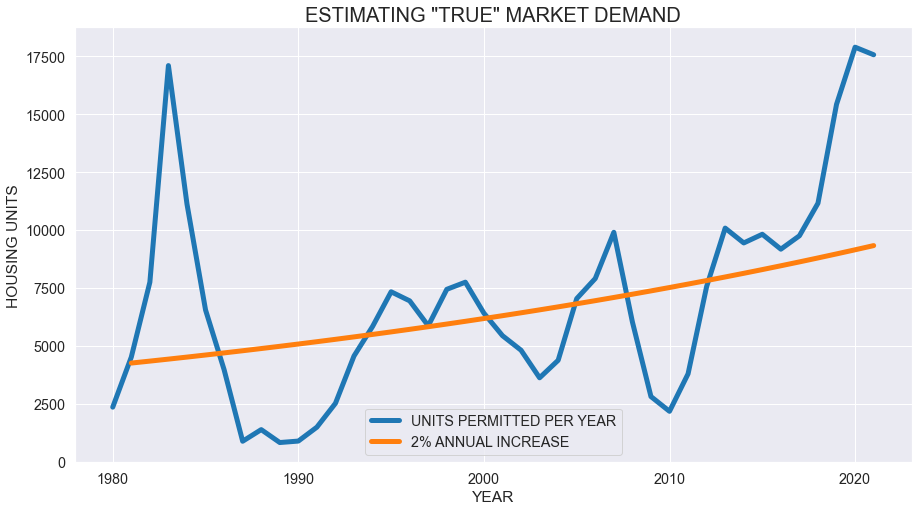

In [20]:
mask = piv.index<=2021
plt.figure(figsize=(15,8))
plt.plot(piv.index[mask], piv['units_issued'][mask], color=qualitative_colors[0], lw=5, label='UNITS PERMITTED PER YEAR')
plt.plot(piv.index[mask], piv['yearly_2%p'][mask], color=qualitative_colors[1], lw=5, label="2% ANNUAL INCREASE")


plt.title('ESTIMATING "TRUE" MARKET DEMAND', fontsize=20)
plt.legend()
plt.xlabel('YEAR')
plt.ylabel('HOUSING UNITS')

plt.savefig('11.png', facecolor='w')
plt.show()

Using this 2% annual increase line as an estimate for "true" market demand effectively smooths out the housing demand as expressed by units permitted per year. Additionally, since this line is independant from the housing supply, we can use this line to compare theoretical demand to actual supply and see where there has been housing surplus from overbuilding and housing shortage from inadequate supply. This allows us to understand the context of the current building boom and see how the resulting wave of supply will effect the market. 

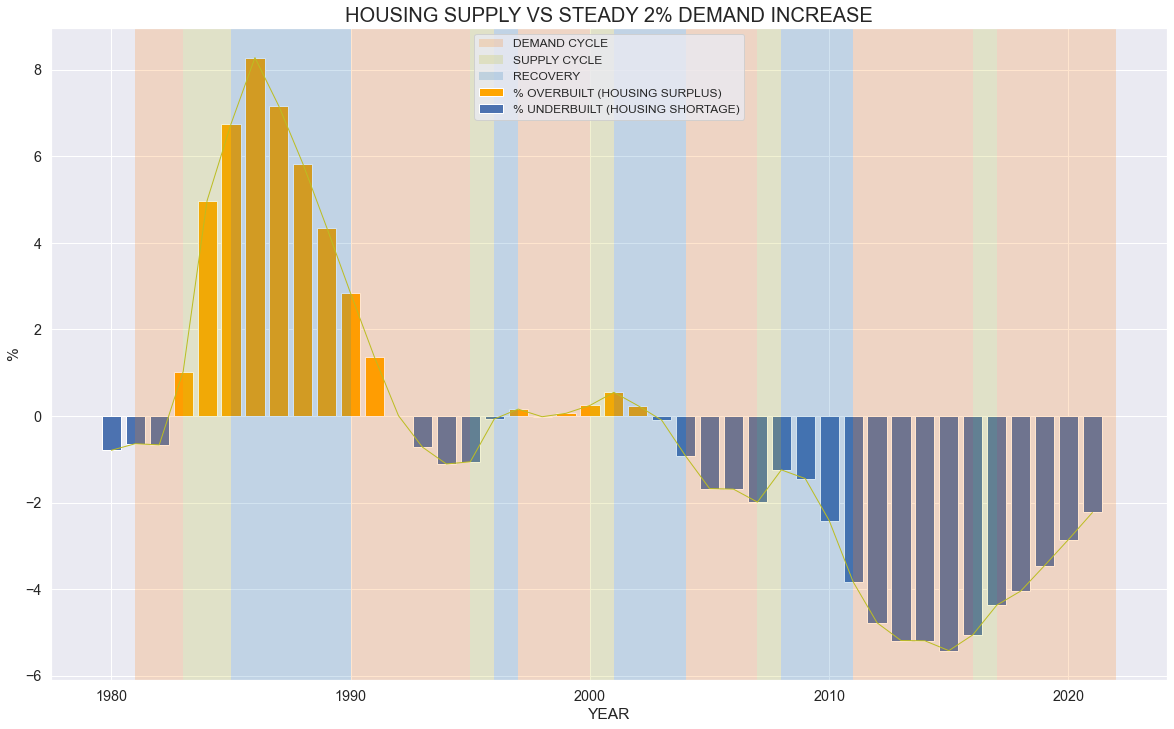

In [21]:
fig, ax2 = plt.subplots(figsize=(20,12))

d = (piv.index <= 2021)
ax2.plot(piv.index[d],
         piv['c_diff'][d],
         color=qualitative_colors[8],
         lw=1,
         label='',
         solid_joinstyle='round',
         solid_capstyle='round')


p = (piv['c_diff'] >= 0) & (piv.index <= 2021)
ax2.bar(piv.index[p],
         height = piv['c_diff'][p],
         color='orange',
         #lw=5, 
         label='% OVERBUILT (HOUSING SURPLUS)')

n = (piv['c_diff'] < 0) & (piv.index <= 2021)
ax2.bar(piv.index[n],
         height = piv['c_diff'][n],
         color='b',
         #lw=5, 
         label='% UNDERBUILT (HOUSING SHORTAGE)')

ax2.axvspan(pd.to_datetime('1981-01').year, pd.to_datetime('1983-06').year , color=qualitative_colors[1], alpha=0.2, lw=0, label='DEMAND CYCLE')
ax2.axvspan(pd.to_datetime('1983-06').year, pd.to_datetime('1985-01').year, color=qualitative_colors[8], alpha=0.2, lw=0, label='SUPPLY CYCLE')
ax2.axvspan(pd.to_datetime('1985-01').year, pd.to_datetime('1990-06').year, color=qualitative_colors[0], alpha=0.2, lw=0, label='RECOVERY')
ax2.axvspan(pd.to_datetime('1990-06').year, pd.to_datetime('1995-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1995-06').year, pd.to_datetime('1996-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1996-06').year, pd.to_datetime('1997-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1997-06').year, pd.to_datetime('2000-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2000-01').year, pd.to_datetime('2001-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2001-06').year, pd.to_datetime('2004-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2004-06').year, pd.to_datetime('2007-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2007-06').year, pd.to_datetime('2008-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2008-06').year, pd.to_datetime('2011-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2011-06').year, pd.to_datetime('2016-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2016-01').year, pd.to_datetime('2017-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2017-06').year, pd.to_datetime('2022-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)

ax2.set_title('HOUSING SUPPLY VS STEADY 2% DEMAND INCREASE', fontsize=20)
ax2.set_ylabel('%')
ax2.set_xlabel('YEAR')
plt.legend(loc='upper center', fontsize=12)

plt.savefig('12.png', facecolor='w')
plt.show()

This chart shows the massive overbuilding in the early 80's, followed by a long period of relatively neutral growth up until around the recession of 2008. New home construction ground to a halt during the recession and Austin has been in a period of housing shortage ever since. Despite high rates of new housing construction over the past 5+ years, the housing supply has not been able to catch up and at the end of 2021, Austin had a housing shortage just over 2% or almost 11,000 housing units. 

Seeing the current market as an ongoing housing shortage helps to explain why the Austin home and rental prices have skyrocketed over the past few years. However, with over 32,000 housing units currently under construction, and more than 2,000 new housing units already permitted in 2022, the housing supply finally seems poised to catch up to the demand and perhaps even enter another period of housing surplus. 

So when will this pent-up new housing arrive to the market?

In [22]:
# this is a dataset with aggregated totals per year generated using a predicitive model and adding delay time 
#     to currently uncompleted projects that were estimated to be completed by now. 

est = pd.read_csv("est.csv", index_col=0)
est.index = pd.to_datetime(est.index)
est = est.resample('y').sum()                  
est.index = pd.to_datetime(est.index).year

In [23]:
# manually adding housing units per future year to account for future projects permitted

# low, mid, high numbers build each year, 0,1,2
i2011 = [952, 2443, 388]  
i2016 = [1277, 4289, 2099]
i2019 = [2313, 4552, 8215]

# totals built for low, mid, high modeling
n2011 = 3783
n2016 = 7665
n2019 = 15080

# 2011 numbers
est_low = est.copy()
est_low.loc[2022, 'total'] += 950
est_low.loc[2023, 'total'] += (950 + 2443)
est_low.loc[2024, 'total'] += (950 + 2443 + 388)



# 2016 numbers
est_mid = est.copy()

est_mid.loc[2022, 'total'] += 1270
est_mid.loc[2023, 'total'] += (1270 + 4289)
est_mid.loc[2024, 'total'] += (1270 + 4289 + 2099)

# 2019 normal times prediction numbers
est_high = est.copy()
est_high.loc[2022, 'total'] += 2300
est_high.loc[2023, 'total'] += (2300 + 4550)
est_high.loc[2024, 'total'] += (2300 + 4550 + 8215)

In [24]:
# building dfimation dfs
def estimation_df_func(df):
    df['tally'] = df['total'].cumsum()

    #adding a column for housing units
    df['h_total'] = 0

    #this is a known variable from the above website
    HOUSING_UNITS_2015 = 405_387
    #filter for the row of year 2015
    mask = df.index == pd.to_datetime('2015').year
    df.loc[mask, 'h_total'] = HOUSING_UNITS_2015

    # adding housing unit values for years less than 2015
    mask = df.index < pd.to_datetime('2015').year
    for i, year in enumerate(df.index[mask].sort_values(ascending=False)):
        mask1 = df.index == (2015 - i)
        added = df.loc[mask1,'total'].sum()
        #print(added)
        current = df.loc[mask1, 'h_total'].sum()
        #print(current)
        previous = current - added
        mask2 = df.index == year
        df.loc[mask2, 'h_total'] = previous

    # adding housing unit values for years over 2015
    mask = df.index > 2015
    for i, year in enumerate(df.index[mask]):
        # selecting previous year for old total
        mask1 = df.index == (2015 + i)
        current = df.loc[mask1, 'h_total'].sum()
       # selecting current year for units added
        mask2 = df.index==year
        added = df.loc[mask2,'total'].sum()
        next_year = current + added
        df.loc[mask2, 'h_total'] = next_year
        
    return df

est_low = estimation_df_func(est_low)
est_mid = estimation_df_func(est_mid)
est_high = estimation_df_func(est_high)

In [25]:
def est_housing_inc(df, year, percentage):
    """plot the increase of housing demand based on mean increase %, for a given year
    
    arg: integer year (1980 - 2022)
    """
    val_df = df[['h_total']].copy()
    year_mask = df.index == year
    INIT_VALUE = 215162                           #est['h_total'][year_mask].sum()
    PERCENTAGE = 1 + (percentage / 100)
    
    col_name = str(year)
    # initializing new column
    val_df[col_name] = 0
    # putting given value in new column
    val_df.loc[year_mask, col_name] = INIT_VALUE
    
    # adding housing unit values for years over given year
    mask = df.index > year
    for i, years in enumerate(df.index[mask]):
        # selecting previous year for old total
        mask1 = val_df.index == (year + i)
        current = val_df.loc[mask1, col_name].sum()
        # selecting current year for units added
        mask2 = val_df.index == years
        next_year = current * PERCENTAGE
        val_df.loc[mask2, col_name] = next_year
        
    # adding housing unit values for years less than given year
    mask = df.index < year

    for i, years in enumerate(df.index[mask].sort_values(ascending=False)):
        mask1 = val_df.index == (year - i)
        current = val_df.loc[mask1, col_name].sum()
        previous = current / PERCENTAGE
        mask2 = val_df.index == years
        val_df.loc[mask2, col_name] = previous
    
    year_series = pd.Series(val_df[col_name])
    return year_series

def finishing_est(df):
    df['2%'] = est_housing_inc(df, 1980, p_increase)
    df['diff'] = ((df['h_total'] - df['2%']) / df['h_total']) * 100
    df = df[df.index >= 1980].copy()
    
    return df

est_low = finishing_est(est_low)
est_mid = finishing_est(est_mid)
est_high = finishing_est(est_high)

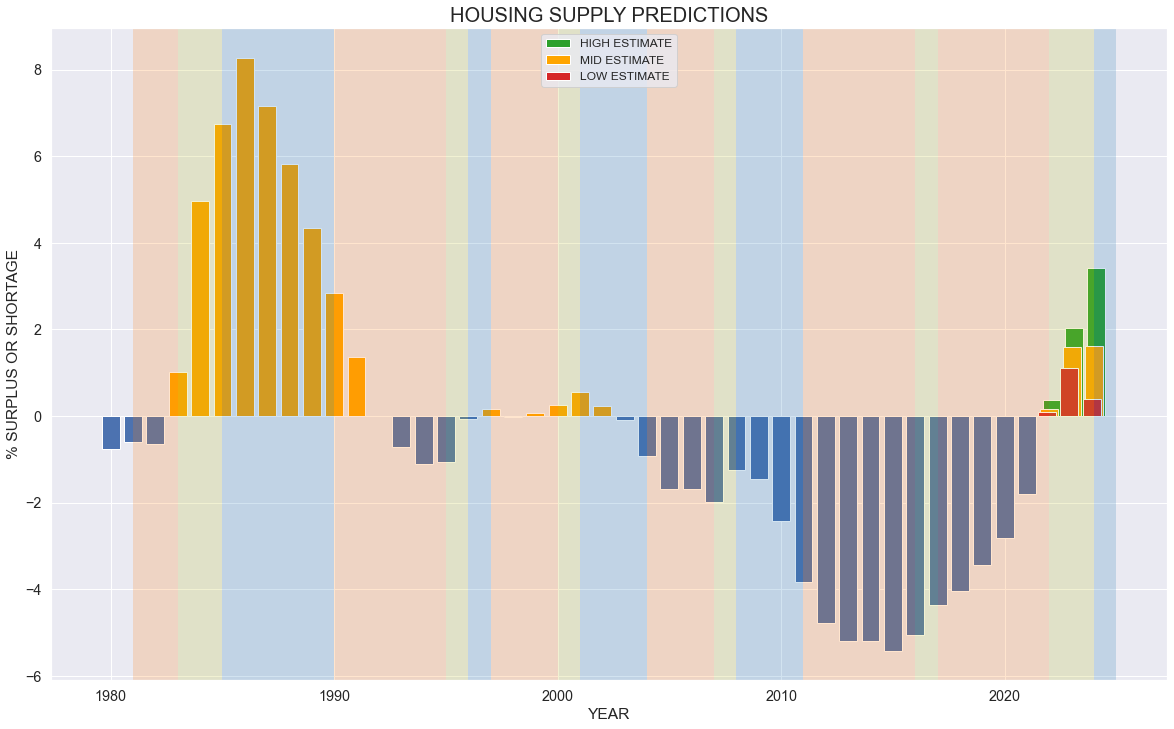

In [26]:
fig, ax2 = plt.subplots(figsize=(20,12))

d = (est_high.index >= 2022)
ax2.bar(est_high.index[d]+.1,
         height = est_high['diff'][d],
         color=qualitative_colors[2],
         label='HIGH ESTIMATE')

p = (est_mid['diff'] >= 0)
ax2.bar(est_mid.index[p],
         height = est_mid['diff'][p],
         color='orange',
         #lw=5, 
         label='MID ESTIMATE')

n = (est_mid['diff'] < 0) 
ax2.bar(est_mid.index[n],
         height = est_mid['diff'][n],
         color='b',
         #lw=5, 
         label='')

d = (est_low.index >= 2022)
ax2.bar(est_low.index[d]-.1,
         height = est_low['diff'][d],
         color=qualitative_colors[3],
         label='LOW ESTIMATE')

ax2.axvspan(pd.to_datetime('1981-01').year, pd.to_datetime('1983-06').year , color=qualitative_colors[1], alpha=0.2, lw=0) #, label='DEMAND CYCLE')
ax2.axvspan(pd.to_datetime('1983-06').year, pd.to_datetime('1985-01').year, color=qualitative_colors[8], alpha=0.2, lw=0) #, label='SUPPLY CYCLE')
ax2.axvspan(pd.to_datetime('1985-01').year, pd.to_datetime('1990-06').year, color=qualitative_colors[0], alpha=0.2, lw=0) #, label='RECOVERY')
ax2.axvspan(pd.to_datetime('1990-06').year, pd.to_datetime('1995-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1995-06').year, pd.to_datetime('1996-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1996-06').year, pd.to_datetime('1997-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('1997-06').year, pd.to_datetime('2000-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2000-01').year, pd.to_datetime('2001-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2001-06').year, pd.to_datetime('2004-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2004-06').year, pd.to_datetime('2007-06').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2007-06').year, pd.to_datetime('2008-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2008-06').year, pd.to_datetime('2011-06').year, color=qualitative_colors[0], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2011-06').year, pd.to_datetime('2016-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2016-01').year, pd.to_datetime('2017-06').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2017-06').year, pd.to_datetime('2022-01').year, color=qualitative_colors[1], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2022-01').year, pd.to_datetime('2024-01').year, color=qualitative_colors[8], alpha=0.2, lw=0)
ax2.axvspan(pd.to_datetime('2024-01').year, pd.to_datetime('2025-01').year, color=qualitative_colors[0], alpha=0.2, lw=0)

ax2.set_title('HOUSING SUPPLY PREDICTIONS', fontsize=20)
ax2.set_ylabel('% SURPLUS OR SHORTAGE')
ax2.set_xlabel('YEAR')
plt.legend(loc='upper center', fontsize=12)

plt.savefig('13.png', facecolor='w')
plt.show()

# Conclusion and predictions

Even if new building permit trends were to plummet to the recession level low of 2011, Austin housing supply would reach a housing surplus of over 1% for the first time since the early 1990's. However, if building trends only drop back to 2019 levels, that housing surplus could begin closing in on 4%, setting the Austin market up for another big crash. While it will most likely take some time for market prices to adjust to accomodate this surge of new housing once it hits the market, these estimates predict that the current housing insanity should at least start cooling off by the end of this year.

data sets used:

- data_2_22_2022.csv - pulled from the city API on Feb 22, 2022 
- compiled.csv - aggregated data with issued and completed dates that includes predicted completion dates assuming "normal times"
- built.csv - data aggregated by type with only actual completed projects
- austin_p_index.csv - Austin home price index data sourced [here](https://fred.stlouisfed.org/series/ATNHPIUS12420Q), citation below
    - U.S. Federal Housing Finance Agency, All-Transactions House Price Index for Austin-Round Rock-Georgetown, TX (MSA) [ATNHPIUS12420Q], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ATNHPIUS12420Q, March 8, 2022.
- number of housing units in 2015, sourced [here](http://www.civicdashboards.com/city/austin-tx-16000US4805000/total_housing_units)
- piv.csv - aggregated data including 2% growth estimate
- est.csv - aggregated data including project completion estimates for all current projects with time adjustments for covid delays